In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import anndata
from anndata import read_h5ad
import warnings
import umap
warnings.filterwarnings("ignore")
import torch
import math
import random
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class simdatset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = torch.from_numpy(self.X[index]).float().to(device)
        y = torch.from_numpy(self.Y[index]).float().to(device)
        return x, y

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.name = 'ae'
        self.inputdim = input_dim
        self.outputdim = output_dim
        self.encoder = nn.Sequential(nn.Dropout(),
                                     nn.Linear(self.inputdim,512),
                                     nn.CELU(),
                                     nn.Dropout(),
                                     nn.Linear(512,256),
                                     nn.CELU(),
                                     nn.Dropout(),
                                     nn.Linear(256,128),
                                     nn.CELU(),
                                     nn.Dropout(),
                                     nn.Linear(128,64),
                                     nn.CELU(),
                                     nn.Linear(64,output_dim),
                                     )
        
        self.decoder = nn.Sequential(nn.Linear(self.outputdim,64,bias=False),
                                     nn.Linear(64,128,bias=False),
                                     nn.Linear(128,256,bias=False),
                                     nn.Linear(256,512,bias=False),
                                     nn.Linear(512,self.inputdim,bias=False))
        
                                               
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,z):
        return self.decoder(z)

    def sigmatrix(self):
        w0 = self.decoder[0].weight.T
        w1 = self.decoder[1].weight.T
        w2 = self.decoder[2].weight.T
        w3 = self.decoder[3].weight.T
        w4 = self.decoder[4].weight.T
        w01 = torch.mm(w0,w1)
        w02 = torch.mm(w01,w2)
        w03 = torch.mm(w02,w3)
        w04 = torch.mm(w03, w4)
        return torch.abs(w04)

    def forward(self, x):
        sigmatrix = self.sigmatrix()
        z = self.encode(x)
        x_recon = torch.mm(z,sigmatrix)
        return x_recon, z, sigmatrix


def train(model, train_loader, optimizer, epochs=10):
    model.train()
    loss = []
    recon_loss = []
    for i in tqdm(range(epochs)):
        for k, (data, label) in enumerate(train_loader):
            optimizer.zero_grad()
            x_recon, cell_prop, sigm = model(data)
            batch_loss = F.l1_loss(cell_prop, label)+F.l1_loss(x_recon,data)
            batch_loss.backward()
            optimizer.step()
            loss.append(F.l1_loss(cell_prop, label).cpu().detach().numpy())
            recon_loss.append(F.l1_loss(x_recon, data).cpu().detach().numpy())

    return model, loss, recon_loss



def predict(model, data):
    model.eval()
    data = torch.from_numpy(data).float().to(device)
    _, pred, sigmatrix = model(data)
    pred = pred.cpu().detach().numpy()
    sigmatrix = sigmatrix.cpu().detach().numpy()
    return pred, sigmatrix


def adaptive_sigm(model, data, optimizerD, optimizerE, max_iter=5):
    data = torch.from_numpy(data).float().to(device)
    loss = []
    model.eval()
    ori_pred = model.encode(data).detach()
    
    for k in tqdm(range(max_iter)):
        model.eval()
        for i in range(1000):
        
            optimizerD.zero_grad()
            x_recon, _, _ = model(data)
            batch_loss = F.l1_loss(x_recon, data)
            batch_loss.backward()
            optimizerD.step()
            loss.append(batch_loss.cpu().detach().numpy())
    
        
        for i in range(1000):
        
            optimizerE.zero_grad()
            x_recon, pred, _ = model(data)
            batch_loss = F.l1_loss(x_recon, data)+F.l1_loss(ori_pred,pred)
            batch_loss.backward()
            optimizerE.step()
            loss.append(batch_loss.cpu().detach().numpy())
        model.eval()
        ori_pred = model.encode(data).detach()
        
    model.eval()
    pred = model.encode(data)
    sigm = model.sigmatrix()
    
    return sigm.cpu().detach().numpy(), loss, pred.cpu().detach().numpy() 

def RMSEscore(pred, true):
    return np.mean(np.abs(pred - true))


def CCCscore(y_pred, y_true):
    # pred: shape{n sample, m cell}
    ccc_value = 0
    for i in range(y_pred.shape[1]):
        r = np.corrcoef(y_pred[:, i], y_true[:, i])[0, 1]
        # print(r)
        # Mean
        mean_true = np.mean(y_true[:, i])
        mean_pred = np.mean(y_pred[:, i])
        # Variance
        var_true = np.var(y_true[:, i])
        var_pred = np.var(y_pred[:, i])
        # Standard deviation
        sd_true = np.std(y_true[:, i])
        sd_pred = np.std(y_pred[:, i])
        # Calculate CCC
        numerator = 2 * r * sd_true * sd_pred
        denominator = var_true + var_pred + (mean_true - mean_pred) ** 2
        ccc = numerator / denominator
        # print(ccc)
        ccc_value += ccc
    return ccc_value / y_pred.shape[1]

def score(pred, label):
    distance = []
    ccc = []
    new_pred = pred.reshape(-1,1)
    new_label = label.reshape(-1,1)
    distance.append(RMSEscore(new_pred, new_label))
    ccc.append(CCCscore(new_pred, new_label))
    print(distance[0], ccc[0])
    return distance[0], ccc[0]

def showloss(loss):
    plt.figure()
    plt.plot(loss)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.show()
            
def reproducibility(seed=1):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True




In [3]:
def preprocess(trainingdatapath, testx, testy):
    # human brain dataset
    trainset = read_h5ad(trainingdatapath)
    testset = pd.read_csv(testx,index_col=0)
    #display(testset)
    testlabel = pd.read_csv(testy,index_col=0)
    #display(testlabel)
    test_y = testlabel.iloc[:,:].values
    test_y = np.array(test_y,dtype=float)
    ### refraction
    for i, values in enumerate(test_y):
        r_sum = np.sum(values)
        if r_sum == 0:
            pass
        else:
            test_y[i] = test_y[i] / r_sum
    ### find intersect genes
    intersection_genes = list(testset.index.intersection(trainset.var.index))
    print(len(intersection_genes))
    test_x = testset.loc[intersection_genes]
    test_x = test_x.T.values
    simuvar = list(trainset.var.index)
    intersection_gene_position = []
    for gene in intersection_genes:
        intersection_gene_position.append(simuvar.index(gene))
    selected = np.zeros((len(intersection_genes), len(trainset.X)))
    for i in range(selected.shape[0]):
        selected[i] = trainset.X.T[intersection_gene_position[i]]
    train_x = selected.T
    
    
    # merge ex&in-neurons
    trainset.obs['Neurons'] = trainset.obs['ExNeurons']+trainset.obs['InNeurons']
    # find intersect cell proportions
    intersection_cell = list(testlabel.columns.intersection(trainset.obs.columns))
    print(intersection_cell)
    train_y = trainset.obs[intersection_cell].values
    ### refraction
    for i, values in enumerate(train_y):
        r_sum = np.sum(values)
        if r_sum == 0:
            pass
        else:
            train_y[i] = train_y[i] / r_sum
    ### variance cutoff
    label = test_x.var(axis=0) > 0.1
    test_x_new = np.zeros((test_x.shape[0],np.sum(label)))
    train_x_new = np.zeros((train_x.shape[0],np.sum(label)))
    k = 0
    selectgenes = []
    for i in range(len(label)):
        if label[i] == True:
            test_x_new[:,k] = test_x[:,i]
            train_x_new[:,k] = train_x[:,i]
            selectgenes.append(intersection_genes[i])
            k += 1
    
    return train_x_new, train_y, test_x_new, test_y, selectgenes, intersection_cell

In [4]:
train_x, train_y, test_x, test_y, genename, celltypes = preprocess(trainingdatapath='../humanbrain/GSE67835.h5ad', 
                                                                   testx='../ROSMAP_human_GEP.csv', 
                                                                   testy='../ROSMAP_IHC_fractions.csv')
train_x = np.log2(train_x + 1)
test_x = np.log2(test_x + 1)
# train_x, test_x = transformation(train_x, test_x)
mms = MinMaxScaler()
test_x = mms.fit_transform(test_x.T)
test_x = test_x.T
train_x = mms.fit_transform(train_x.T)
train_x = train_x.T
print('train_x shape',train_x.shape)
print('train_y shape',train_y.shape)
print('test_x shape',test_x.shape)
print('test_y shape',test_y.shape)

12905
['Astrocytes', 'Endothelial', 'Microglia', 'Neurons', 'Oligodendrocytes']
train_x shape (2000, 11897)
train_y shape (2000, 5)
test_x shape (41, 11897)
test_y shape (41, 5)


In [5]:
ori_sigm = pd.read_csv("../humanbrain/GSE67835signature_matrix.csv",index_col=0)
ori_sigm_genename = list(ori_sigm.columns)
ori_sigm_genename = [x.replace(" ","") for x in ori_sigm_genename]
ori_sigm.columns = ori_sigm_genename
ori_sigm = ori_sigm[genename]
ori_sigm.loc['Neurons'] = ori_sigm.loc['ExNeurons']+ori_sigm.loc['InNeurons']
ori_sigm = ori_sigm.loc[celltypes].values
print(ori_sigm.shape)
ori_sigm = np.log2(ori_sigm+1)
ori_sigm = mms.fit_transform(ori_sigm.T)
ori_sigm = ori_sigm.T

(5, 11897)


100%|██████████| 300/300 [00:43<00:00,  6.93it/s]


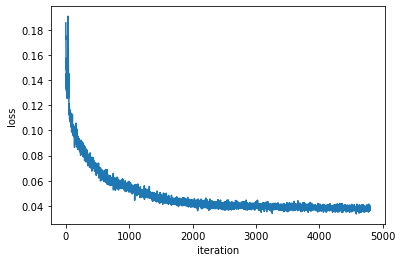

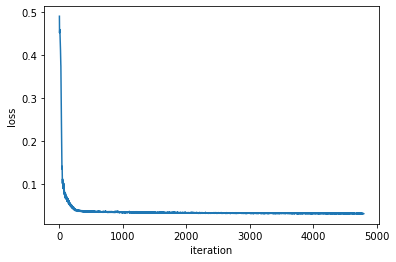

100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


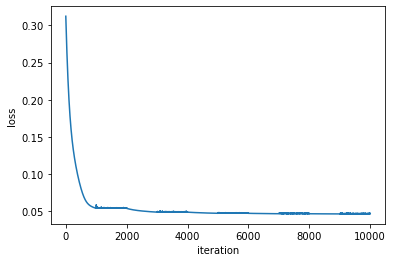

0.04408461485179941 0.9252286698329024
0.04408461485179941 0.9252286698329024
0.04392088012045639 0.9256691234104176
0.04392088012045639 0.9256691234104176


In [6]:
reproducibility(seed=0)
train_loader = data.DataLoader(simdatset(train_x, train_y), batch_size=128, shuffle=True)
test_loader = data.DataLoader(simdatset(test_x, test_y), batch_size=len(test_x), shuffle=False)
model = AutoEncoder(train_x.shape[1], train_y.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
model, loss, reconloss = train(model, train_loader, optimizer, epochs=300)
showloss(loss)
showloss(reconloss)
pred, train_sigm = predict(model, test_x)
decoder_parameters = [{'params': [p for n, p in model.named_parameters() if 'decoder' in n]}]
encoder_parameters = [{'params': [p for n, p in model.named_parameters() if 'encoder' in n]}]
optimizerD = torch.optim.Adam(decoder_parameters, lr=1e-5)
optimizerE = torch.optim.Adam(encoder_parameters, lr=1e-5)
test_sigm, loss, test_pred = adaptive_sigm(model, test_x, optimizerD, optimizerE, max_iter=5)
showloss(loss)
l1, ccc = score(pred,test_y)
print(l1, ccc)
l1, ccc = score(test_pred,test_y)
print(l1, ccc)

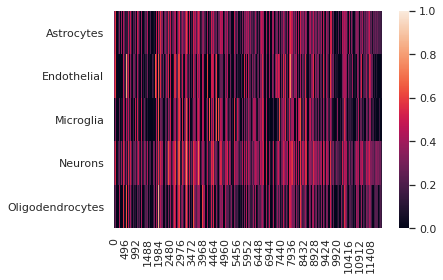

In [7]:
sns.set()
ax = sns.heatmap(ori_sigm,yticklabels=celltypes,vmin=0)
plt.show()

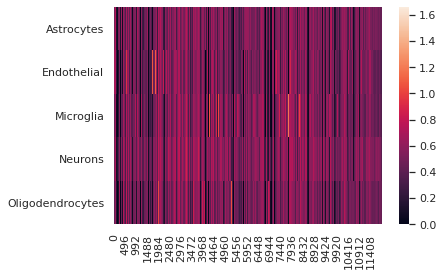

In [8]:
# train_sigm = mms.fit_transform(train_sigm.T)
# train_sigm = train_sigm.T
sns.set()
ax = sns.heatmap(train_sigm,yticklabels=celltypes,vmin=0)
plt.show()

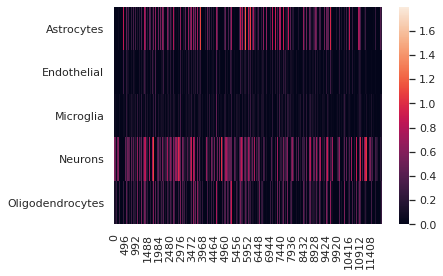

In [9]:
# test_sigm = mms.fit_transform(test_sigm.T)
# test_sigm = test_sigm.T
sns.set()
#color = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

ax = sns.heatmap(test_sigm, yticklabels=celltypes,vmin=0)
plt.show()

In [10]:
top10 = np.argsort(ori_sigm[3,:])[-10:]

for index in top10:
    print(genename[index])
print("**********************")
top10 = np.argsort(train_sigm[3,:])[-10:]
for index in top10:
    print(genename[index])
print("**********************")
top10 = np.argsort(test_sigm[3,:])[-10:]
for index in top10:
    print(genename[index])

DCX
NFIB
CALM2
PPP1CB
HSP90AA1
STMN1
TUBA1A
DPYSL2
MAP1B
MALAT1
**********************
CALM2
NFIB
STMN2
STMN1
PPP1CB
HSP90AA1
TUBA1A
DPYSL2
MAP1B
MALAT1
**********************
KIF5C
SYNPO
CACNG3
PNMA3
NRGN
LMO4
NEFH
NAP1L3
NAPB
GLUL


In [11]:
position1 = np.zeros_like(ori_sigm[3,:])
for i, index in enumerate(np.argsort(ori_sigm[3,:])):
    position1[index] = i
position2 = np.zeros_like(train_sigm[3,:])
for i, index in enumerate(np.argsort(train_sigm[3,:])):
    position2[index] = i   

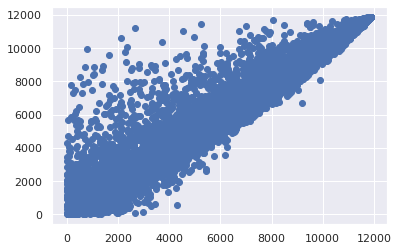

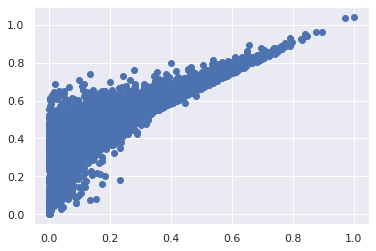

In [12]:
plt.scatter(position1[:], position2)
plt.show()
plt.scatter(ori_sigm[3,:],train_sigm[3,:])

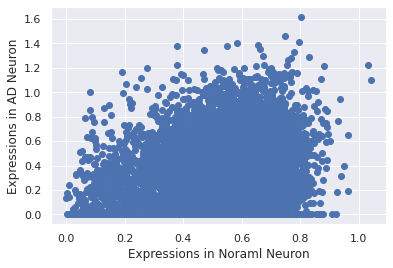

In [13]:
normal_neuron = train_sigm[3,:]
AD_neuron = test_sigm[3,:]
plt.xlabel("Expressions in Noraml Neuron")
plt.ylabel("Expressions in AD Neuron")
plt.scatter(normal_neuron, AD_neuron)
plt.show()

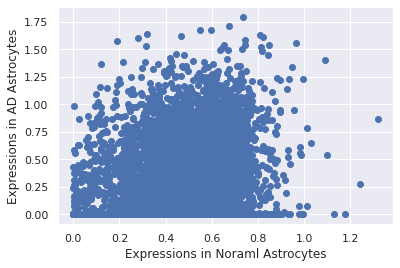

In [14]:
normal_astro = train_sigm[0,:]
AD_astro = test_sigm[0,:]
plt.xlabel("Expressions in Noraml Astrocytes")
plt.ylabel("Expressions in AD Astrocytes")
plt.scatter(normal_astro, AD_astro)
plt.show()

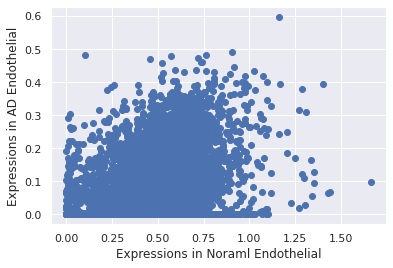

In [15]:
normal_endo = train_sigm[1,:]
AD_endo = test_sigm[1,:]
plt.xlabel("Expressions in Noraml Endothelial")
plt.ylabel("Expressions in AD Endothelial")
plt.scatter(normal_endo, AD_endo)
plt.show()

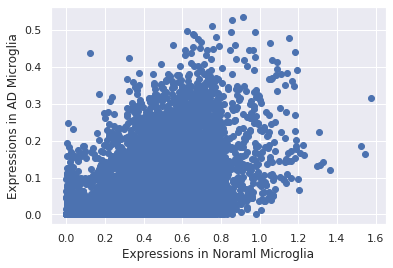

In [16]:
normal_micro = train_sigm[2,:]
AD_micro = test_sigm[2,:]
plt.xlabel("Expressions in Noraml Microglia")
plt.ylabel("Expressions in AD Microglia")
plt.scatter(normal_micro, AD_micro)
plt.show()

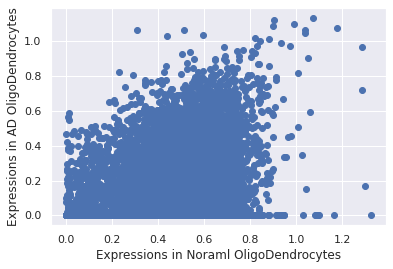

In [17]:
normal_od = train_sigm[4,:]
AD_od = test_sigm[4,:]
plt.xlabel("Expressions in Noraml OligoDendrocytes")
plt.ylabel("Expressions in AD OligoDendrocytes")
plt.scatter(normal_od, AD_od)